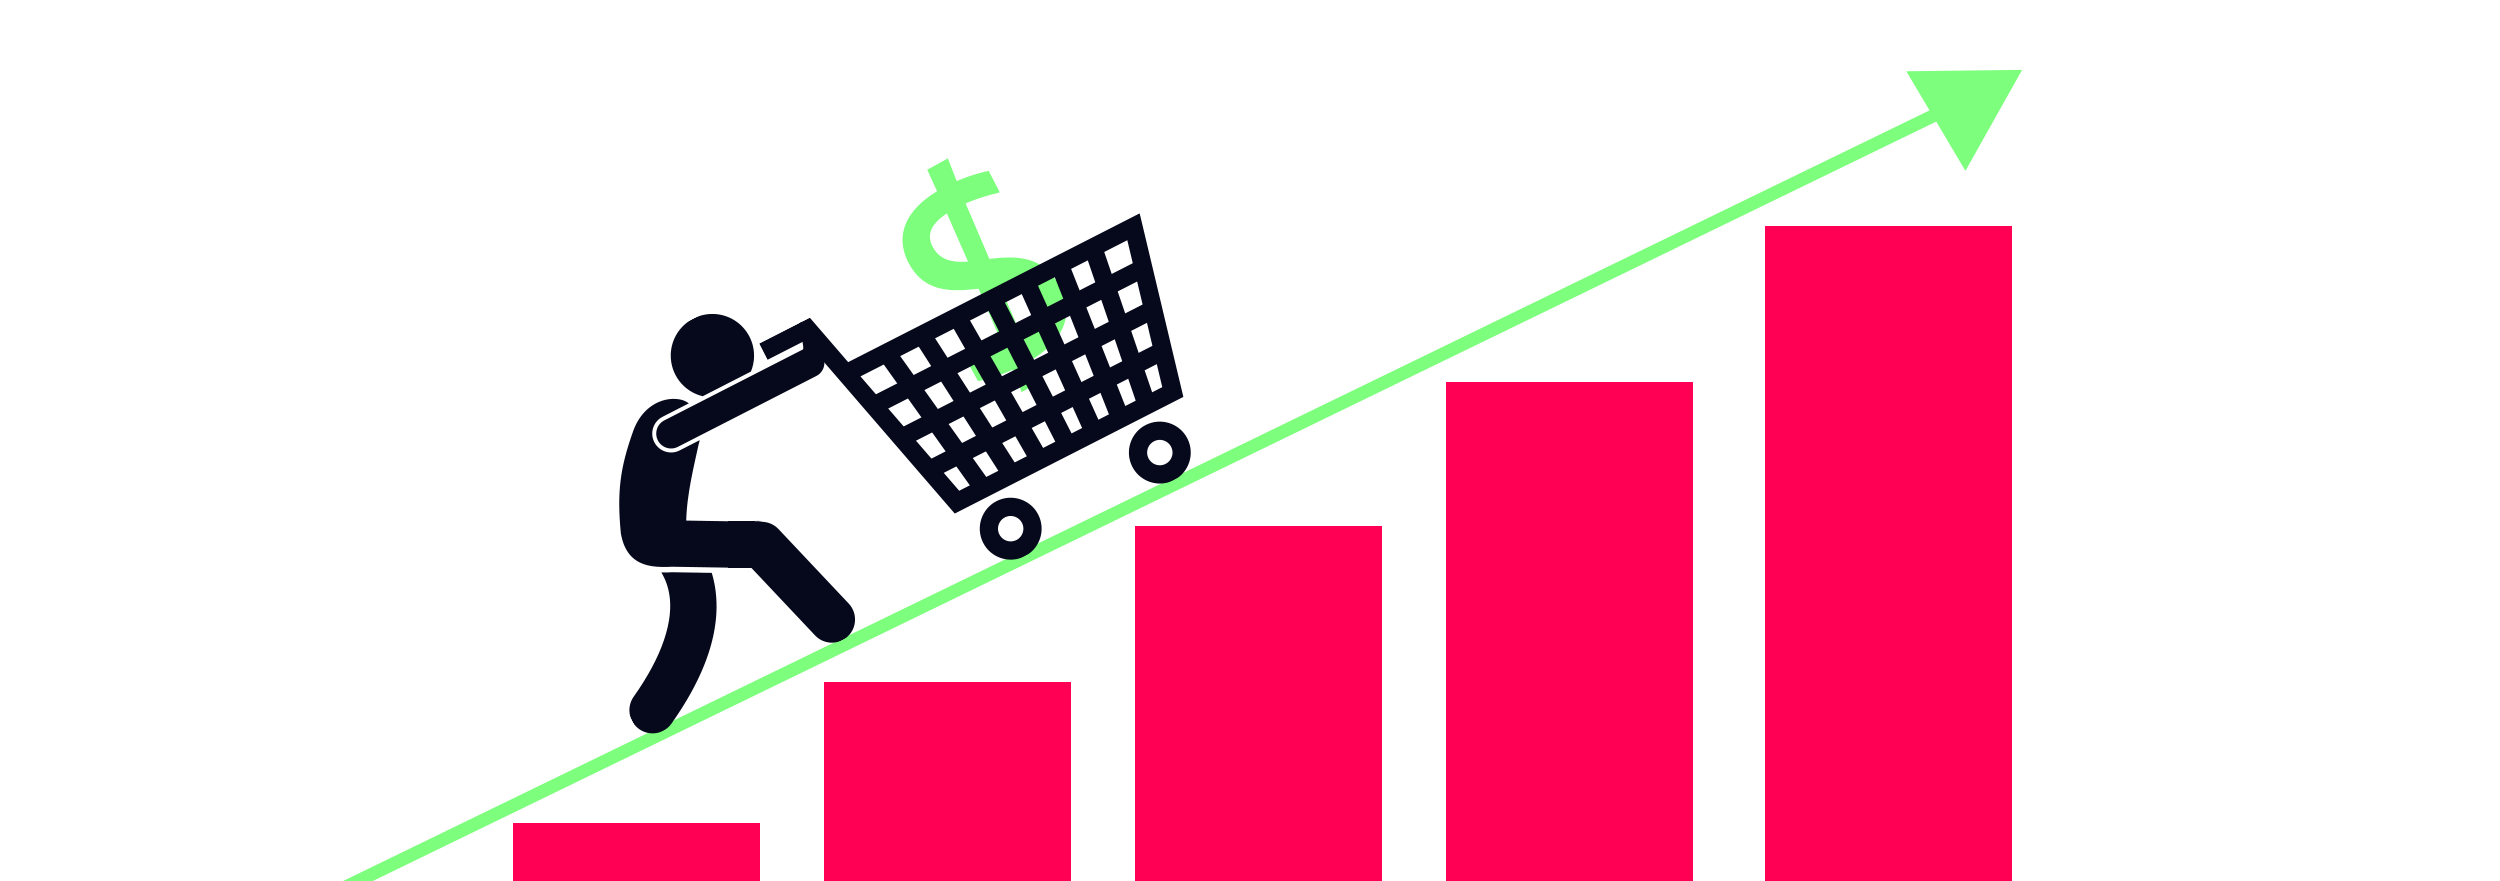

# Кейс: Прогнозирование продаж
#### Прогнозирование продаж является важной задачей для бизнеса, так как позволяет более точно планировать производство, запасы, маркетинговые кампании и финансовые ресурсы. В данном проекте вам предстоит разработать модель машинного обучения для прогнозирования объема продаж на основе исторических данных, представленных в формате CSV.

#### Основная цель проекта — создать модель, которая сможет предсказать будущие продажи с высокой точностью, используя различные данные, такие как предыдущие продажи, сезонные тренды и другие факторы. Наша модель должна помочь бизнесу принимать более обоснованные решения.

In [1]:
#Импорт модулей
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np 
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
warnings.filterwarnings('ignore')
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

In [2]:
train = pd.read_csv('/kaggle/input/netology/train.csv')
test = pd.read_csv('/kaggle/input/netology/test.csv')
stores = pd.read_csv('/kaggle/input/netology/stores.csv')
features = pd.read_csv('/kaggle/input/netology/features.csv')

# Описание датасета:

#### train.csv содержит данные о еженедельных продажах.

* Store: Идентификатор магазина.
* Dept: Идентификатор отдела.
* Date: Дата продаж (в формате YYYY-MM-DD).
* Weekly_Sales: Объем продаж за неделю.
* IsHoliday: Указатель на праздничную неделю (1 - да, 0 - нет).
 

# Дополнительные файлы:

#### features.csv: Дополнительные экономические данные и информация о промо-акциях.

* Store: Идентификатор магазина.
* Date: Дата (в формате YYYY-MM-DD).
* Temperature: Средняя температура за неделю.
* Fuel_Price: Цена на топливо.
* MarkDown1: Скидка 1.
* MarkDown2: Скидка 2.
* MarkDown3: Скидка 3.
* MarkDown4: Скидка 4.
* MarkDown5: Скидка 5.
* CPI: Индекс потребительских цен.
* Unemployment: Уровень безработицы.
* IsHoliday: Указатель на праздничную неделю (1 - да, 0 - нет).

#### stores.csv: Информация о магазинах.

* Store: Идентификатор магазина.
* Type: Тип магазина.
* Size: Размер магазина (в квадратных футах).

# **Первичная обработка данных**

#### Объединим основной датасет с дополнительными файлами про экономические факторы и информацию о магазинах. 

In [3]:
train_1 = pd.merge(train, stores, how='inner', on='Store')
test_1 = pd.merge(test, stores, how='inner', on='Store')

df_train = pd.merge(train_1, features, how='inner', on=['Store', 'Date', 'IsHoliday'])
df_test = pd.merge(test_1, features, how='inner', on=['Store', 'Date', 'IsHoliday'])

#### Заметим, что данные MarkDown содержат значения NaN, так как только эти данные заполнены NaN и должны быть нам известны cо стороны магазинов точно, то вероятно они должны значить нулевую скидку.

In [4]:
print('Null:')
print(df_train.isnull().sum())

Null:
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
dtype: int64


In [5]:
df_train.fillna(0, inplace=True)

#### Заметим что IsHoliday типа bool, поэтому для удобства приведем к типу int

In [6]:
df_train["IsHoliday"] = df_train["IsHoliday"].astype(int)
df_test["IsHoliday"] = df_test["IsHoliday"].astype(int)

In [7]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,0,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,1,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,0,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,0,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,0,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


#### Создадим функцию для подсчета дубликатов и пропущенных значений в train и test

In [8]:
def Summ_Nan(df_train, df_test):
    print('For train')
    print('Duplicated:', sum(df_train.duplicated()))
    print('Null:')
    print(df_train.isnull().sum())
    print()
    print('For test')
    print('Duplicated:', sum(df_test.duplicated()))
    print('Null:')
    print(df_test.isnull().sum())
    
Summ_Nan(df_train, df_test)

For train
Duplicated: 0
Null:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
dtype: int64

For test
Duplicated: 0
Null:
Store               0
Dept                0
Date                0
IsHoliday           0
Type                0
Size                0
Temperature         0
Fuel_Price          0
MarkDown1         149
MarkDown2       28627
MarkDown3        9829
MarkDown4       12888
MarkDown5           0
CPI             38162
Unemployment    38162
dtype: int64


#### Функция считает дубликаты и пропущенные значения в тренировочных и тестовых данных. Чтобы избавиться от них.

#### Разобьем Date на отдельные столбцы day, month, year

In [9]:
# Преобразуем тип от строки к datetime
df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

# Сортируем датасет по дате
df_train = df_train.sort_values(by='Date', ascending=True)
df_test = df_test.sort_values(by='Date', ascending=True)


# Создаем отдельные столбцы, которые составляют дату, для train датасета
df_train['day'] = df_train['Date'].dt.day
df_train["day"] = df_train["day"].astype(int)

df_train['month'] = df_train['Date'].dt.month
df_train["month"] = df_train["month"].astype(int)

df_train['year'] = df_train['Date'].dt.year
df_train["year"] = df_train["year"].astype(int)

df_train['week'] = df_train['Date'].dt.isocalendar().week
df_train["week"] = df_train["week"].astype(int)

# Удаляем столбец Date
df_train = df_train.drop(columns=['Date'])


# Создаем отдельные столбцы, которые составляют дату, для test датасета
df_test['day'] = df_test['Date'].dt.day
df_test["day"] = df_test["day"].astype(int)

df_test['month'] = df_test['Date'].dt.month
df_test["month"] = df_test["month"].astype(int)

df_test['year'] = df_test['Date'].dt.year
df_test["year"] = df_test["year"].astype(int)

df_test['week'] = df_test['Date'].dt.isocalendar().week
df_test["week"] = df_test["week"].astype(int)

# Удаляем столбец Date
df_test = df_test.drop(columns=['Date'])

#### Объединим скидки в один столбец Discount

In [10]:
df_train['Discount'] = df_train['MarkDown1'] + df_train['MarkDown2'] + df_train['MarkDown3'] + df_train['MarkDown4'] + df_train['MarkDown5']
df_train = df_train.drop(columns=['MarkDown1','MarkDown2','MarkDown3', 'MarkDown4', 'MarkDown5'])

df_test['Discount'] = df_test['MarkDown1'] + df_test['MarkDown2'] + df_test['MarkDown3'] + df_test['MarkDown4'] + df_test['MarkDown5']
df_test = df_test.drop(columns=['MarkDown1','MarkDown2','MarkDown3', 'MarkDown4', 'MarkDown5'])

### Обратим внимание на параметр CPI
#### Если посмотреть на значения CPI, то будет видно, что значения меняются на порядок быстрее, чем недельные продажи. Выглядит это скорее как некоторый малый рост + шум. График ниже это илюстрирует. И учитывая малый рост, с достаточной степенью точности мы можем взять медианые значения позиции, с отсутствиющимися значениями.

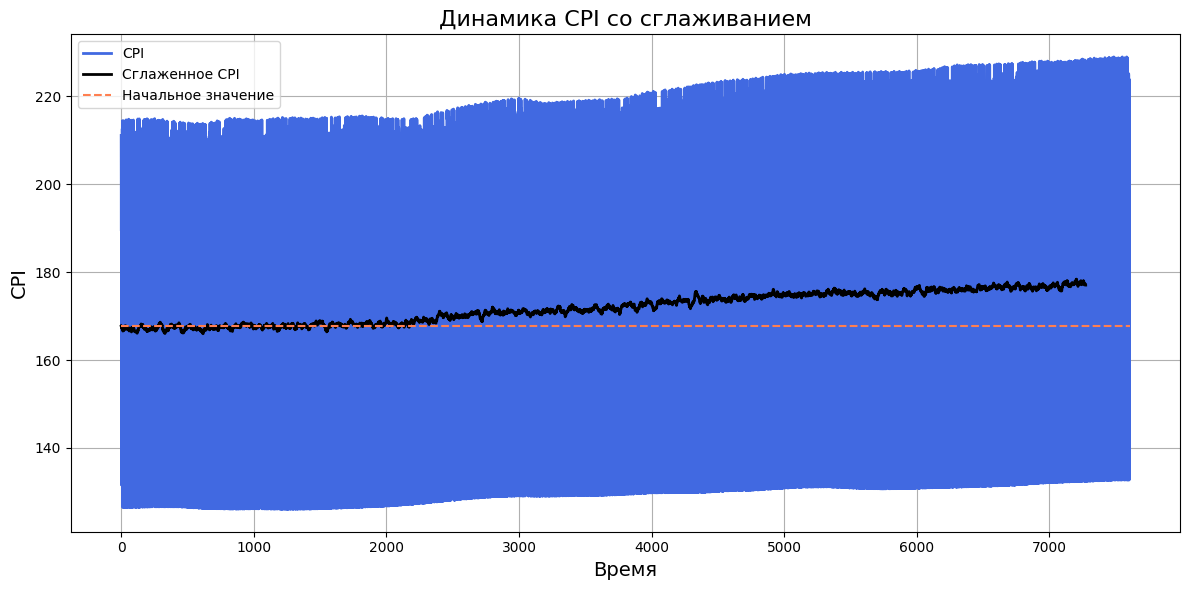

In [11]:
# Сортировка и сброс индексов
features2 = features.sort_values(by='Date').reset_index(drop=True)

# Создание фигуры
plt.figure(figsize=(12, 6))

# Удаление NaN значений
A = features2['CPI']
A = A[~np.isnan(A)]

# Параметры сглаживания
dl = 160
B = np.linspace(0, 0, len(A) - 2 * dl)

# Сглаживание данных
for i in range(dl, len(A) - 1 - dl, 1):
    B[i - dl] = sum(A[i - dl:i + dl]) / (2 * dl + 1)

# Построение графиков
plt.plot(A, color='royalblue', label='CPI', linewidth=2)
plt.plot(B[:-10], color='k', label='Сглаженное CPI', linewidth=2)
plt.plot([0, len(A)], [B[0], B[0]], '--', color='coral', label='Начальное значение')

# Настройка графика
plt.title('Динамика CPI со сглаживанием', fontsize=16)
plt.xlabel('Время', fontsize=14)
plt.ylabel('CPI', fontsize=14)
plt.legend()
plt.grid(True)

# Отображение графика
plt.tight_layout()
plt.show()

#### Пропущенные значения для CPI и Unemployment в test датасете заменим на медианные значения

In [12]:
median_value = df_test['CPI'].median()
df_test.fillna({'CPI': median_value}, inplace=True)

median_value = df_test['Unemployment'].median()
df_test.fillna({'Unemployment': median_value}, inplace=True)

#### Также занулим пропущенные значения скидок

In [13]:
df_test.fillna(0, inplace=True)

#### Закодируем столбец Type с помощью LabelEncoder

In [14]:
le = LabelEncoder()
df_train['Type']= le.fit_transform(df_train['Type'])
df_test['Type']= le.fit_transform(df_test['Type'])

In [15]:
df_train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,day,month,year,week,Discount
0,1,1,24924.50,0,0,151315,42.31,2.572,211.096358,8.106,5,2,2010,5,0.0
277665,29,5,15552.08,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.0
277808,29,6,3200.22,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.0
277951,29,7,10820.05,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.0
278094,29,8,20055.64,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.0


In [16]:
Summ_Nan(df_train, df_test)

For train
Duplicated: 0
Null:
Store           0
Dept            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
day             0
month           0
year            0
week            0
Discount        0
dtype: int64

For test
Duplicated: 0
Null:
Store           0
Dept            0
IsHoliday       0
Type            0
Size            0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
day             0
month           0
year            0
week            0
Discount        0
dtype: int64


# **EDA & Feature engineering**

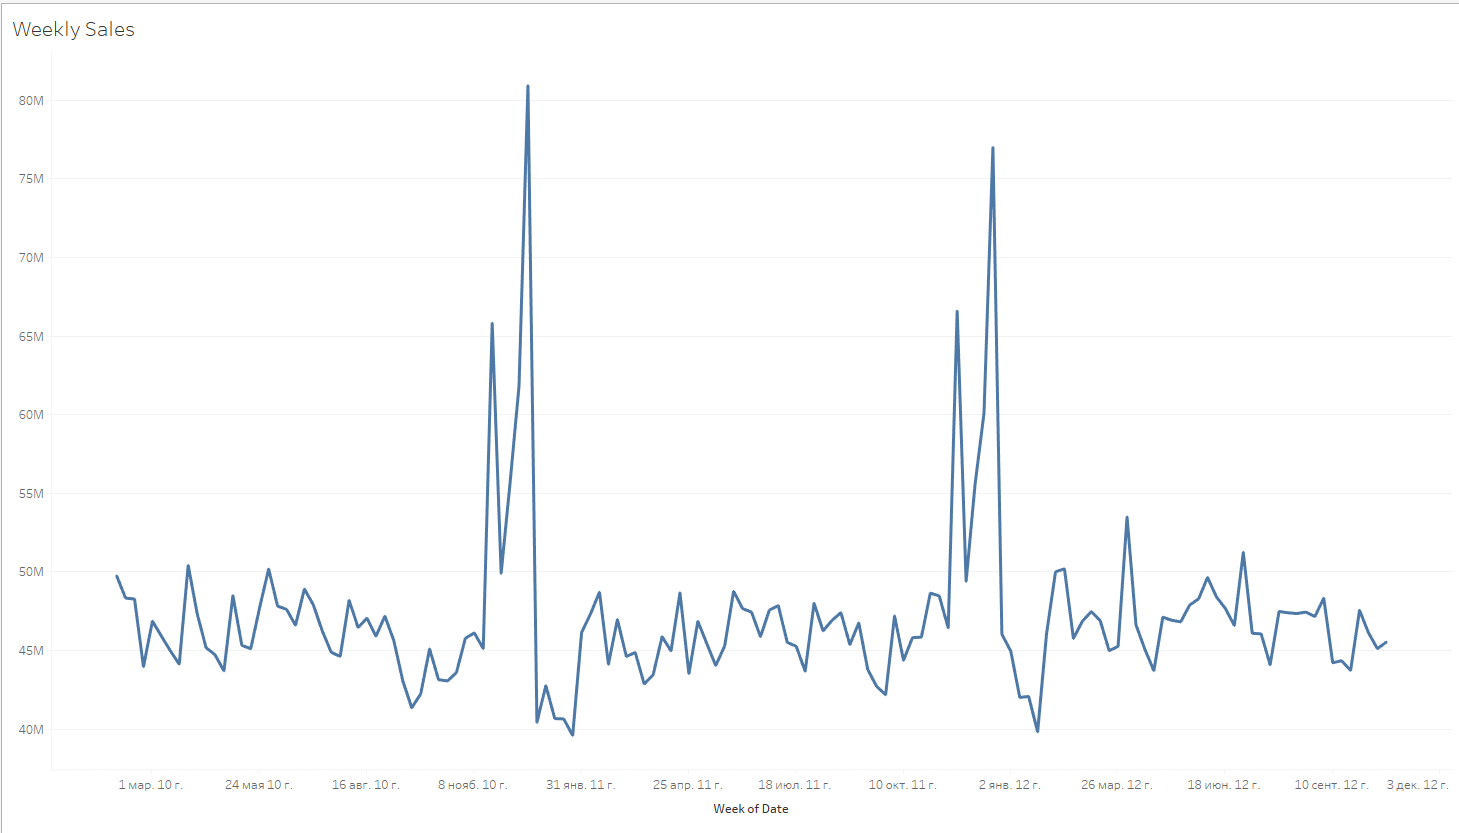

#### Видны отчетливые пики в праздники(День Благодарения и зимние праздники)

#### Рассмотрим распределение Weekly_Sales

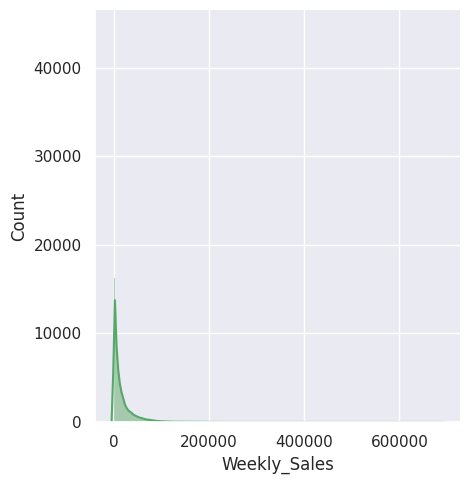

In [17]:
sns.set(rc={"figure.figsize": (20, 15)})

sns.displot(data=df_train, x="Weekly_Sales", kde=True, color = 'g')

#### Заметим, что есть как отрицательные значения, так и нулевые. Избавимся от них.

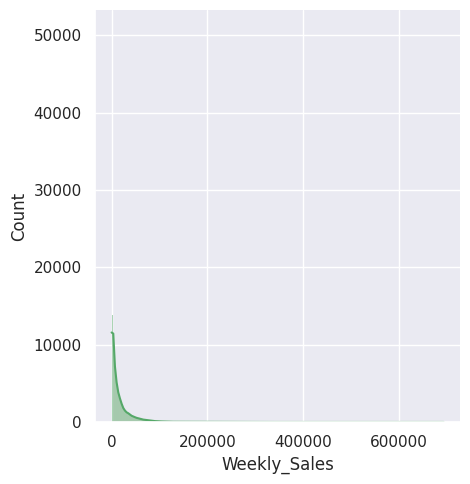

In [18]:
df_norm = df_train[(df_train['Weekly_Sales'] >= 1)]
sns.displot(data=df_norm, x="Weekly_Sales", kde=True, color = 'g')

In [19]:
df_norm

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,day,month,year,week,Discount
0,1,1,24924.50,0,0,151315,42.31,2.572,211.096358,8.106,5,2,2010,5,0.00
277665,29,5,15552.08,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.00
277808,29,6,3200.22,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.00
277951,29,7,10820.05,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.00
278094,29,8,20055.64,0,1,93638,24.36,2.788,131.527903,10.064,5,2,2010,5,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379648,40,87,24638.96,0,0,155083,49.65,3.917,138.728161,4.145,26,10,2012,43,5537.84
181170,19,30,3740.12,0,0,203819,56.49,4.071,138.728161,7.992,26,10,2012,43,8090.93
181313,19,31,3128.17,0,0,203819,56.49,4.071,138.728161,7.992,26,10,2012,43,8090.93
181599,19,33,5740.14,0,0,203819,56.49,4.071,138.728161,7.992,26,10,2012,43,8090.93


#### Попробуем создать новые параметры на основе старых

In [20]:
df_new_features = df_norm.copy()

# Влияние месяца и температуры
df_new_features['Month_Temperature'] = df_new_features['month'] * df_new_features['Temperature']

# Влияние месяца и скидки
df_new_features['Seasonal_Discount'] = df_new_features['Discount'] * df_new_features['month']

# Экономические факторы
df_new_features['Store_Size_Economic_Effect'] = df_new_features['CPI'] * df_new_features['Unemployment'] * df_new_features['Fuel_Price']

# Специфические признаки магазинов
df_new_features['Store_Specific_Effect'] = df_new_features['Dept'] * df_new_features['Size']

# **Моделирование**

#### Разобьем данные на train и test для датасета с новыми преобразованными параметрами и для датасета с исходными параметрами

In [21]:
from sklearn.model_selection import train_test_split

# Разбиваем данные с новыми параметрами на features и target 
y_features = df_new_features.Weekly_Sales
X_features = df_new_features.drop(columns=['Weekly_Sales'])

# Разбиваем исходные данные на features и target
y_norm = df_norm.Weekly_Sales
X_norm = df_norm.drop(columns=['Weekly_Sales'])

# Разделяем данные на train и test
X_train_nf, X_test_nf, y_train_nf, y_test_nf = train_test_split(X_features, y_features, test_size = 0.2, shuffle = False)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_norm, y_norm, test_size = 0.2, shuffle = False)

#### Напишем функцию для подсчета точности модели

In [22]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score

def score(y_test, y_pred):
    print('r2_score:', r2_score(y_test,y_pred))
    print('mean_absolute_error:', mean_absolute_error(y_test,y_pred))
    print('mean_absolute_percentage_error:', mean_absolute_percentage_error(y_test,y_pred))
    print('mean_squared_error:', mean_squared_error(y_test,y_pred))
    print()

#### Для нашей задачи подойдут такие метрики:                                          
##### r2_score - доля дисперсии, которую может объяснить модель                       
##### mean_absolute_error - среднее абсолютной ошибки                          
##### mean_absolute_percentage_error - среднее абсолютной ошибки в процентах                                   
##### mean_squared_error - среднее квадратичной ошибки                                 

#### Нашей задачей является прогноз недельных продаж. Поэтому мы используем регрессионые модели: Линейная регрессия, ElasticNet(Линейная регрессия + L1 и L2 регуляризация, Случайный лес(регрессионый), Градиентный бустинг.

## **Модель 1**
### Линейная регрессия

In [23]:
# Линейная регрссия для данных с дополнительными параметрами
lin = linear_model.LinearRegression()
lin.fit(X_train_nf, y_train_nf)

y_pred = lin.predict(X_test_nf)
print("Точность LinearRegression для данных с дополнительными параметрами")
score(y_test_nf, y_pred)

# Линейная регрссия для данных без дополнительных параметров
lin = linear_model.LinearRegression()
lin.fit(X_train_n, y_train_n)

y_pred = lin.predict(X_test_n)
print("Точность LinearRegression для данных без дополнительных параметров")
score(y_test_n, y_pred)

Точность LinearRegression для данных с дополнительными параметрами
r2_score: 0.10075759123642958
mean_absolute_error: 14665.545095674142
mean_absolute_percentage_error: 70.30405500263447
mean_squared_error: 434972512.1708146

Точность LinearRegression для данных без дополнительных параметров
r2_score: 0.09326196583474877
mean_absolute_error: 14622.081163784615
mean_absolute_percentage_error: 67.68598992231537
mean_squared_error: 438598220.85568786



## **Модель 2**
### ElasticNet

In [24]:
# ElasticNet для данных с дополнительными параметрами
Ela = linear_model.ElasticNet()
Ela.fit(X_train_nf, y_train_nf)

y_pred = Ela.predict(X_test_nf)
print("Точность ElasticNet для данных с дополнительными параметрами")
score(y_test_nf, y_pred)

# ElasticNet для данных без дополнительных параметров
Ela = linear_model.ElasticNet()
Ela.fit(X_train_n, y_train_n)

y_pred = Ela.predict(X_test_n)
print("Точность ElasticNet для данных без дополнительных параметров")
score(y_test_n, y_pred)

Точность ElasticNet для данных с дополнительными параметрами
r2_score: 0.09926989019748667
mean_absolute_error: 14673.98814819044
mean_absolute_percentage_error: 69.54959497177342
mean_squared_error: 435692127.9851508

Точность ElasticNet для данных без дополнительных параметров
r2_score: 0.09224349738255289
mean_absolute_error: 14672.452912091214
mean_absolute_percentage_error: 68.49932814866547
mean_squared_error: 439090864.1929026



#### Заметим, что новые параметры не дают должного прироста точности, поэтому дальше моделировать будем без них

## **Модель 3**
### XGBRegressor

In [25]:
import xgboost as xgb

xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100)
xgb.fit(X_train_n, y_train_n)

y_pred = xgb.predict(X_test_n)
print("Точность RandomForestRegressor")
score(y_test_n, y_pred)

Точность RandomForestRegressor
r2_score: 0.9413651312988285
mean_absolute_error: 3315.3728344786136
mean_absolute_percentage_error: 14.555978529019717
mean_squared_error: 28362270.163417194



## **Модель 4**
### RandomForestRegressor

In [26]:
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train_n, y_train_n)

y_pred = rfr.predict(X_test_n)
print("Точность RandomForestRegressor")
score(y_test_n, y_pred)

Точность RandomForestRegressor
r2_score: 0.9709617121500828
mean_absolute_error: 1767.6854787947038
mean_absolute_percentage_error: 2.3937332554197033
mean_squared_error: 14046109.13822979



#### Рассмотрим какие параметры вносят больший вклад в финальный ответ модели

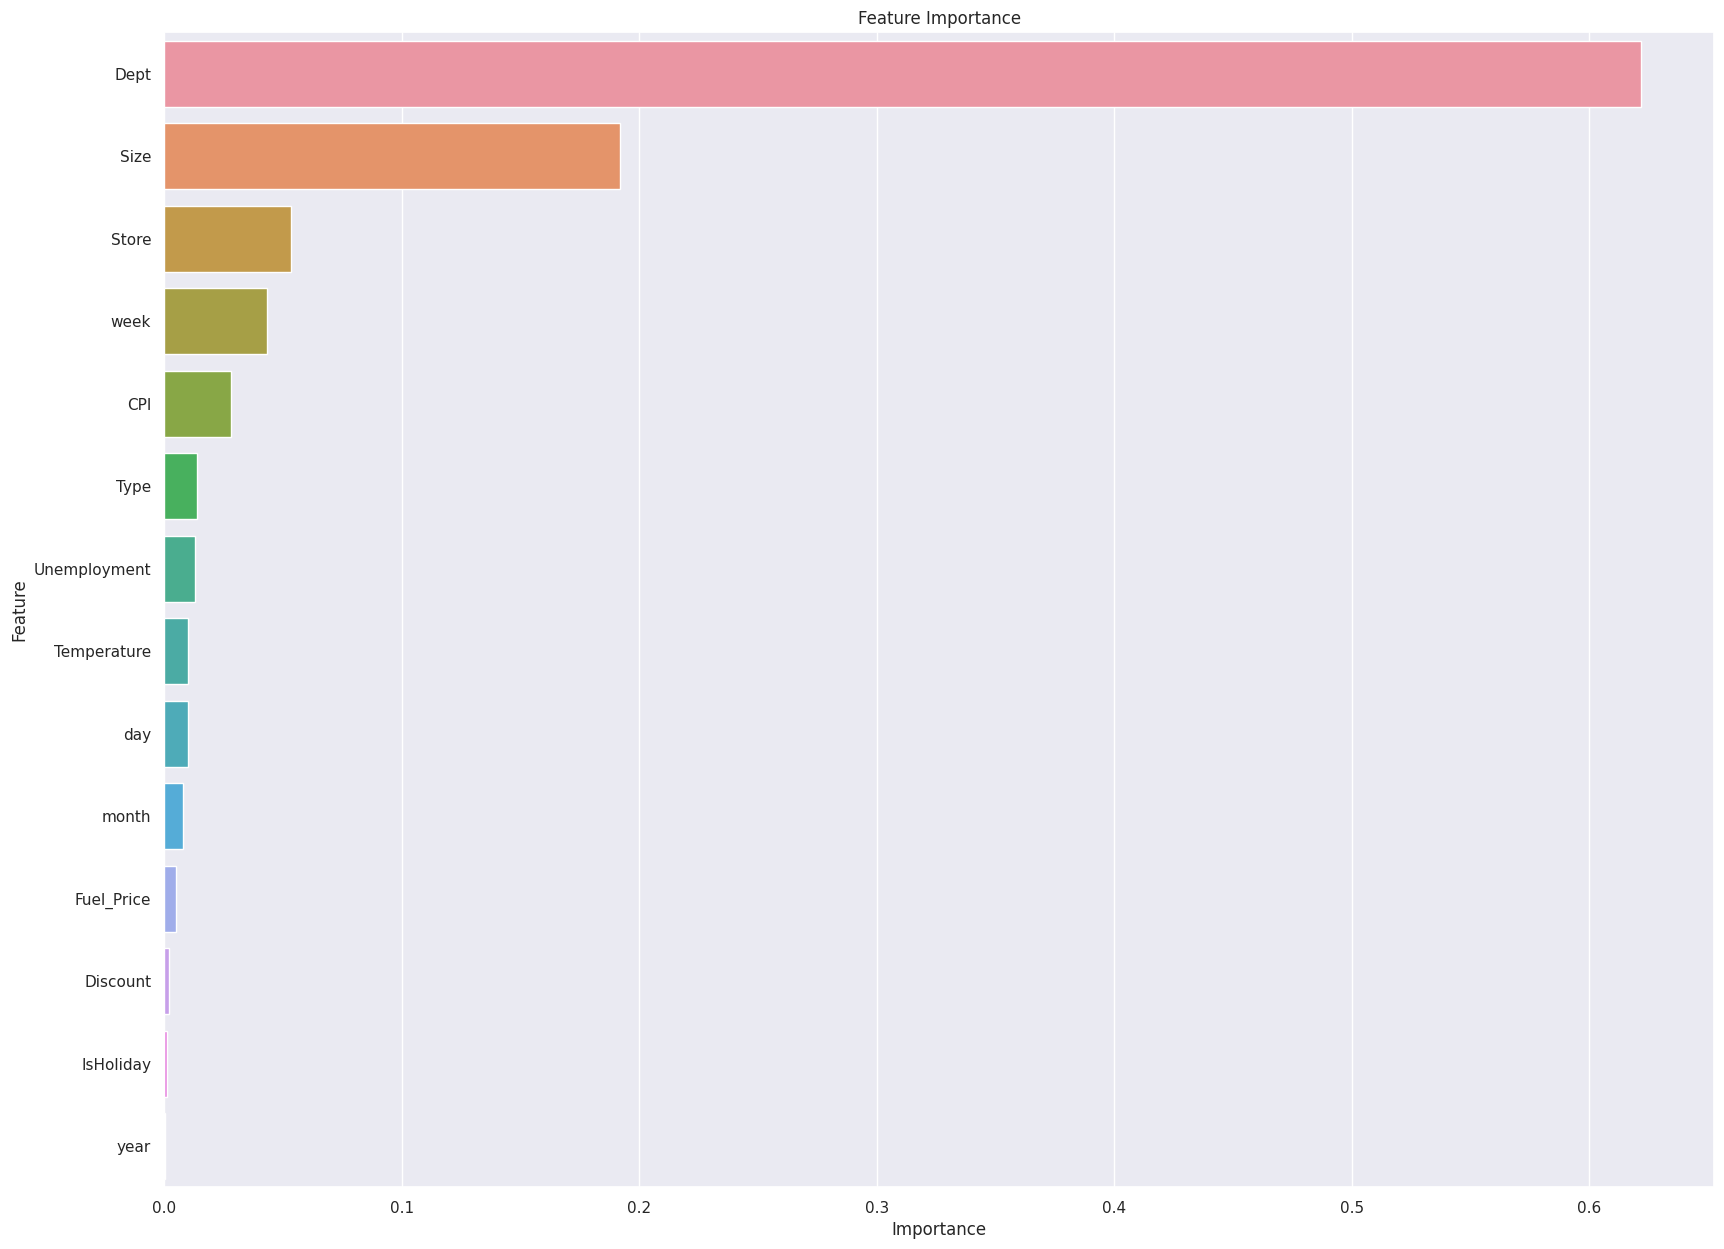

In [27]:
importances = rfr.feature_importances_
feature_names = X_train_n.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

#### Попробуем убрать параметры, которые вносят относительно маленький вклад в ответ

In [28]:
X_train_n_reduce = X_train_n.drop(columns=['IsHoliday', 'year', 'Discount', 'Fuel_Price'])
X_test_n_reduce = X_test_n.drop(columns=['IsHoliday', 'year', 'Discount', 'Fuel_Price'])

rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train_n_reduce, y_train_n)

y_pred = rfr.predict(X_test_n_reduce)
print("Точность RandomForestRegressor без \'IsHoliday\', \'year\', \'Discount\', \'Fuel_Price\'")
score(y_test_n, y_pred)

Точность RandomForestRegressor без 'IsHoliday', 'year', 'Discount', 'Fuel_Price'
r2_score: 0.9719275413573453
mean_absolute_error: 1755.711768787911
mean_absolute_percentage_error: 2.3583283339909733
mean_squared_error: 13578927.92822819



#### Рассмотрим еще раз распределение Weekly_Sales

<Axes: >

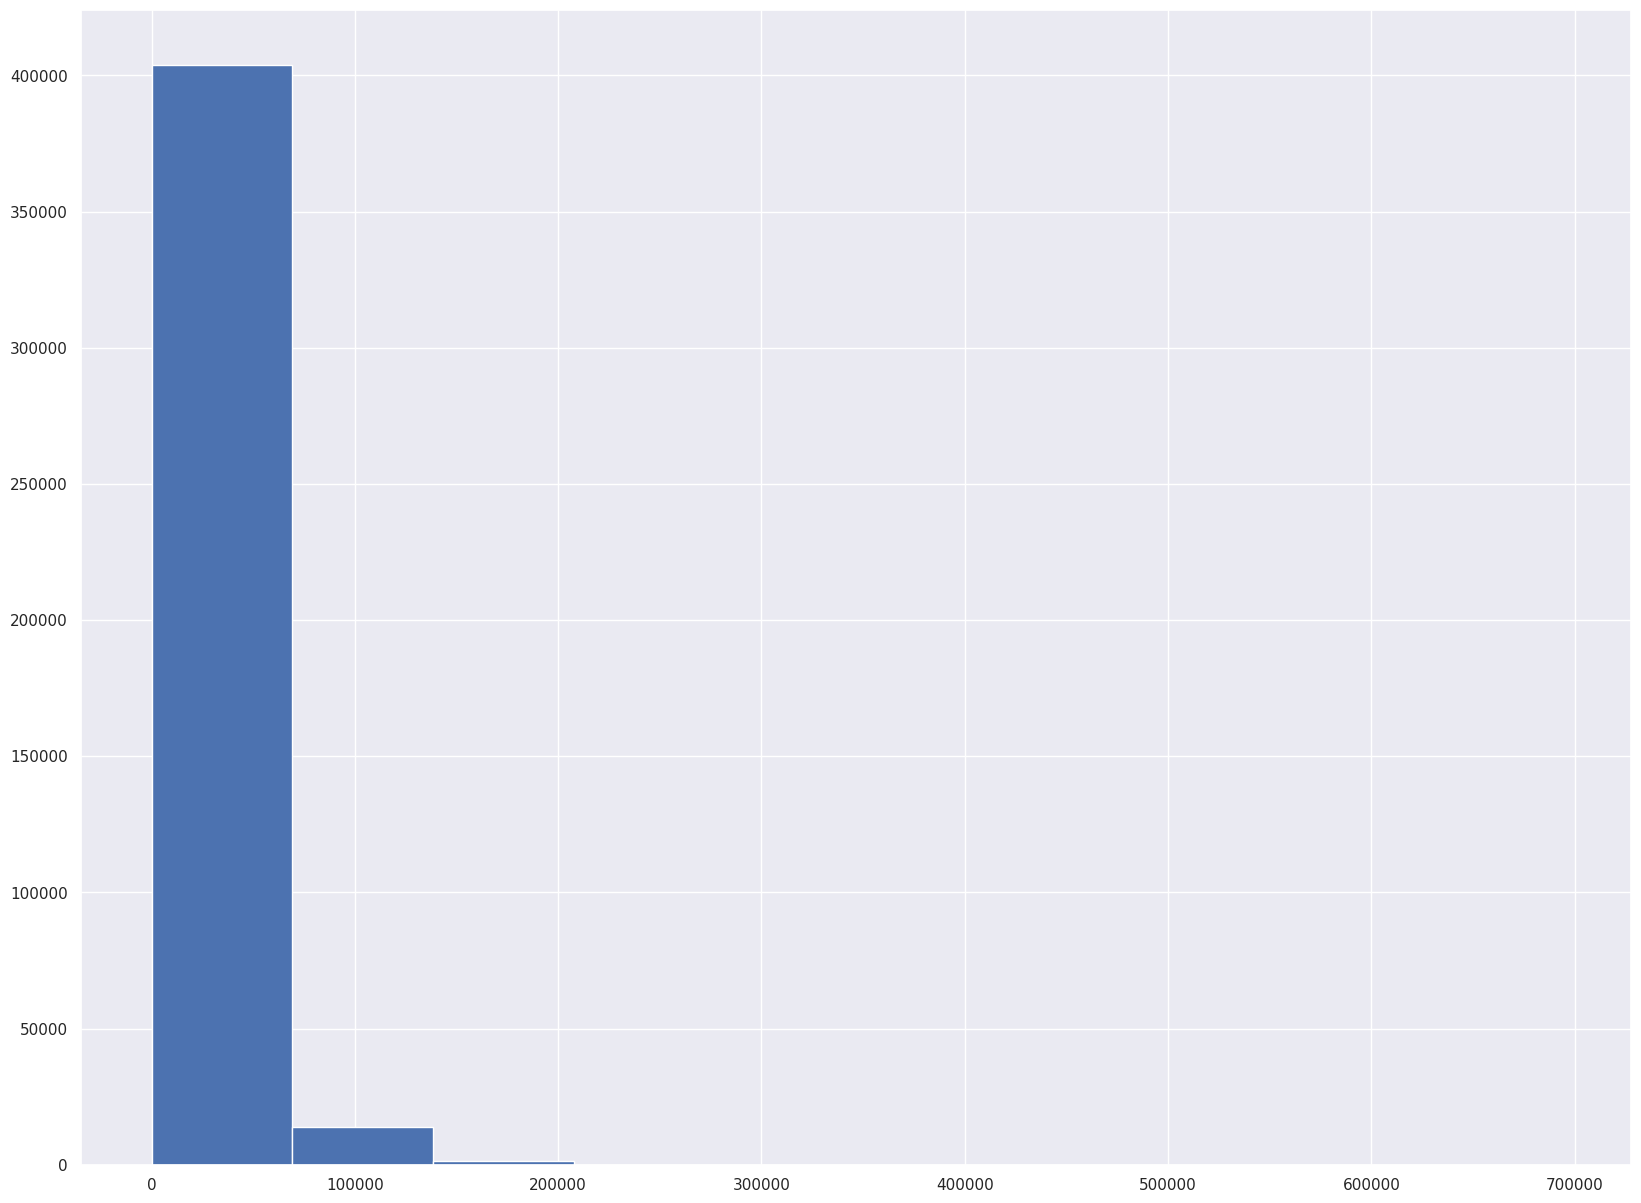

In [29]:
df_norm['Weekly_Sales'].hist()

#### Заметим, что данные имеют приближенное Гамма распределение, но с очень быстрой тенденцией. Попробуем масштабировать данные фильтром.

<Axes: >

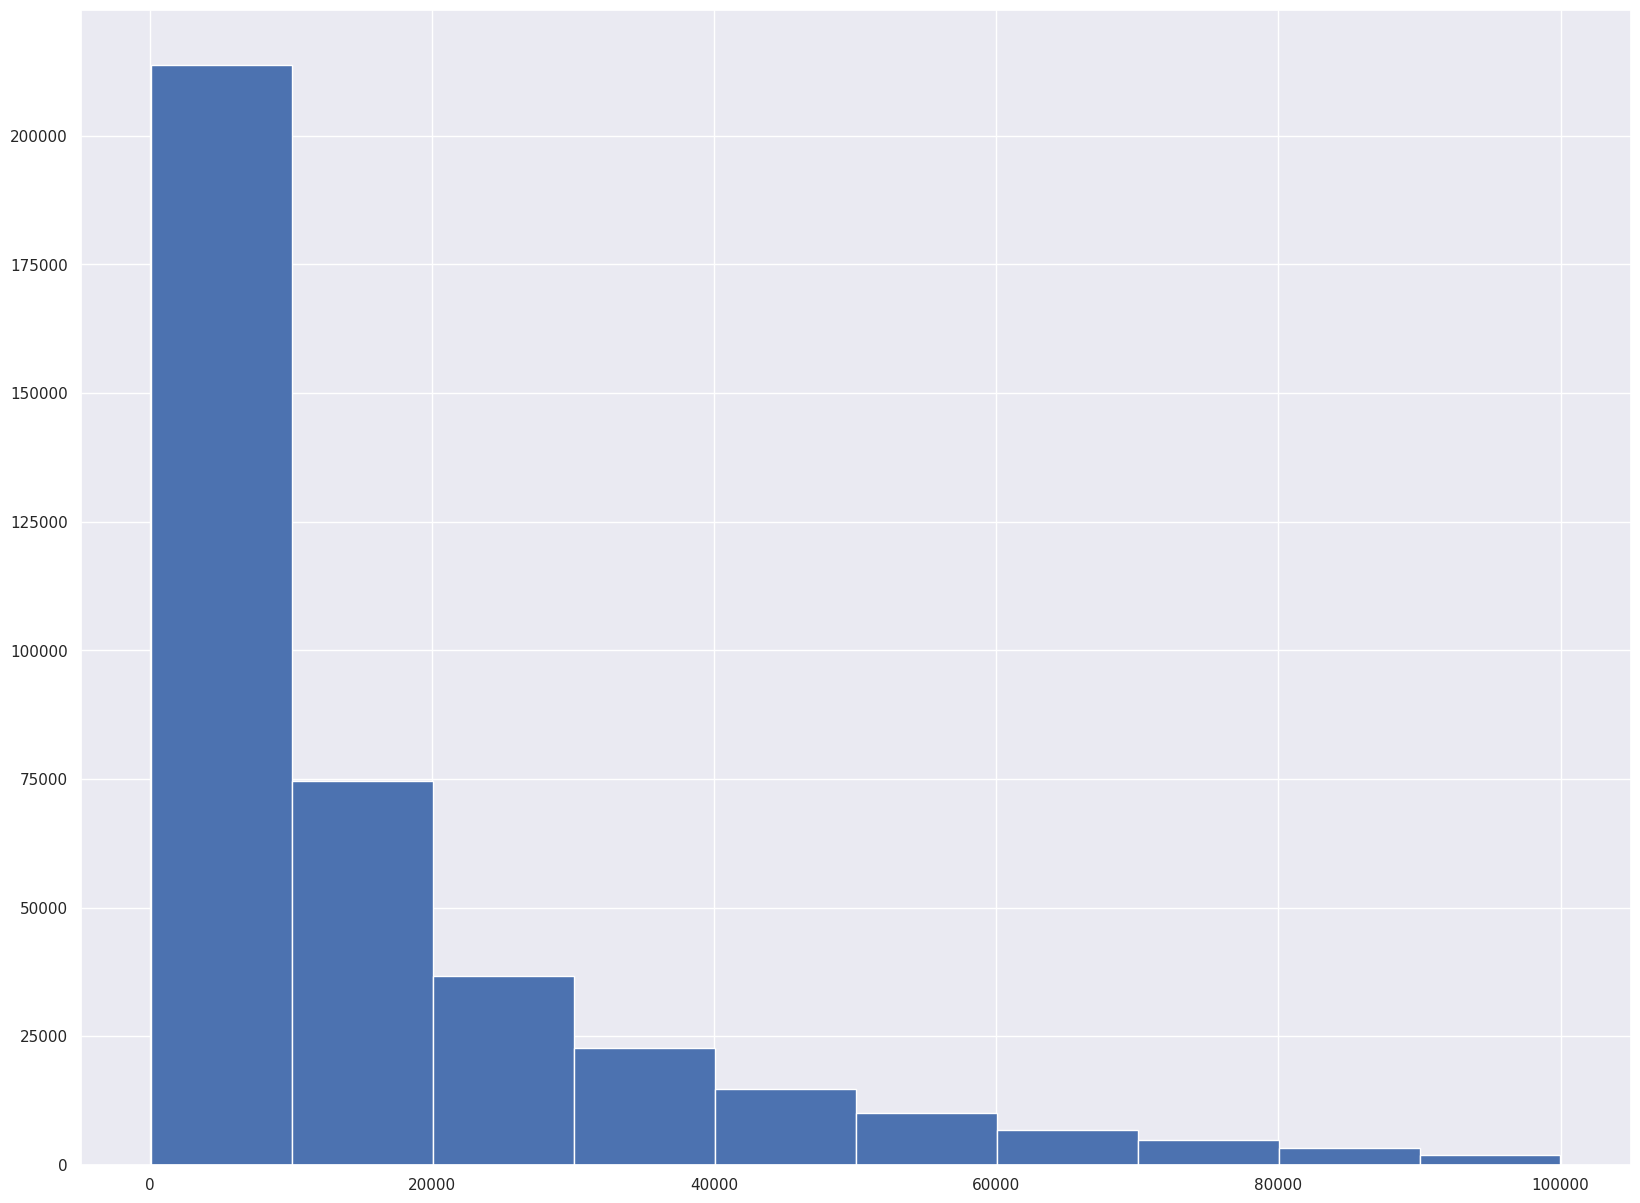

In [30]:
df_norm_reduce = df_norm[(100 < df_norm['Weekly_Sales']) & (df_norm['Weekly_Sales'] < 100_000)]
df_norm_reduce['Weekly_Sales'].hist()

In [31]:
df_norm.shape

(419564, 15)

In [32]:
df_norm_reduce.shape

(389335, 15)

#### Распределение стало с менее резкой тенденцией, а строк стало всего на 30 тысяч меньше, что не является большой потерей. Обучим RandomForestRegressor на этих данных

In [33]:
# Разбиваем данные на features и target
y_norm_reduce = df_norm_reduce.Weekly_Sales
X_norm_reduce = df_norm_reduce.drop(columns=['Weekly_Sales'])

# Разделяем данные на train и test
X_train_nr, X_test_nr, y_train_nr, y_test_nr = train_test_split(X_norm_reduce, y_norm_reduce, test_size = 0.2, shuffle = False)

# Обучаем RandomForestRegressor на этих данных
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train_nr, y_train_nr)

y_pred = rfr.predict(X_test_nr)
print("Точность RandomForestRegressor с 100 < Weekly_Sales < 100_000")
score(y_test_nr, y_pred)

Точность RandomForestRegressor с 100 < Weekly_Sales < 100_000
r2_score: 0.9681092331799644
mean_absolute_error: 1752.5430145440303
mean_absolute_percentage_error: 0.26788248555036903
mean_squared_error: 11083964.65292714



#### Рассмотрим какие параметры вносят больший вклад в финальный ответ модели

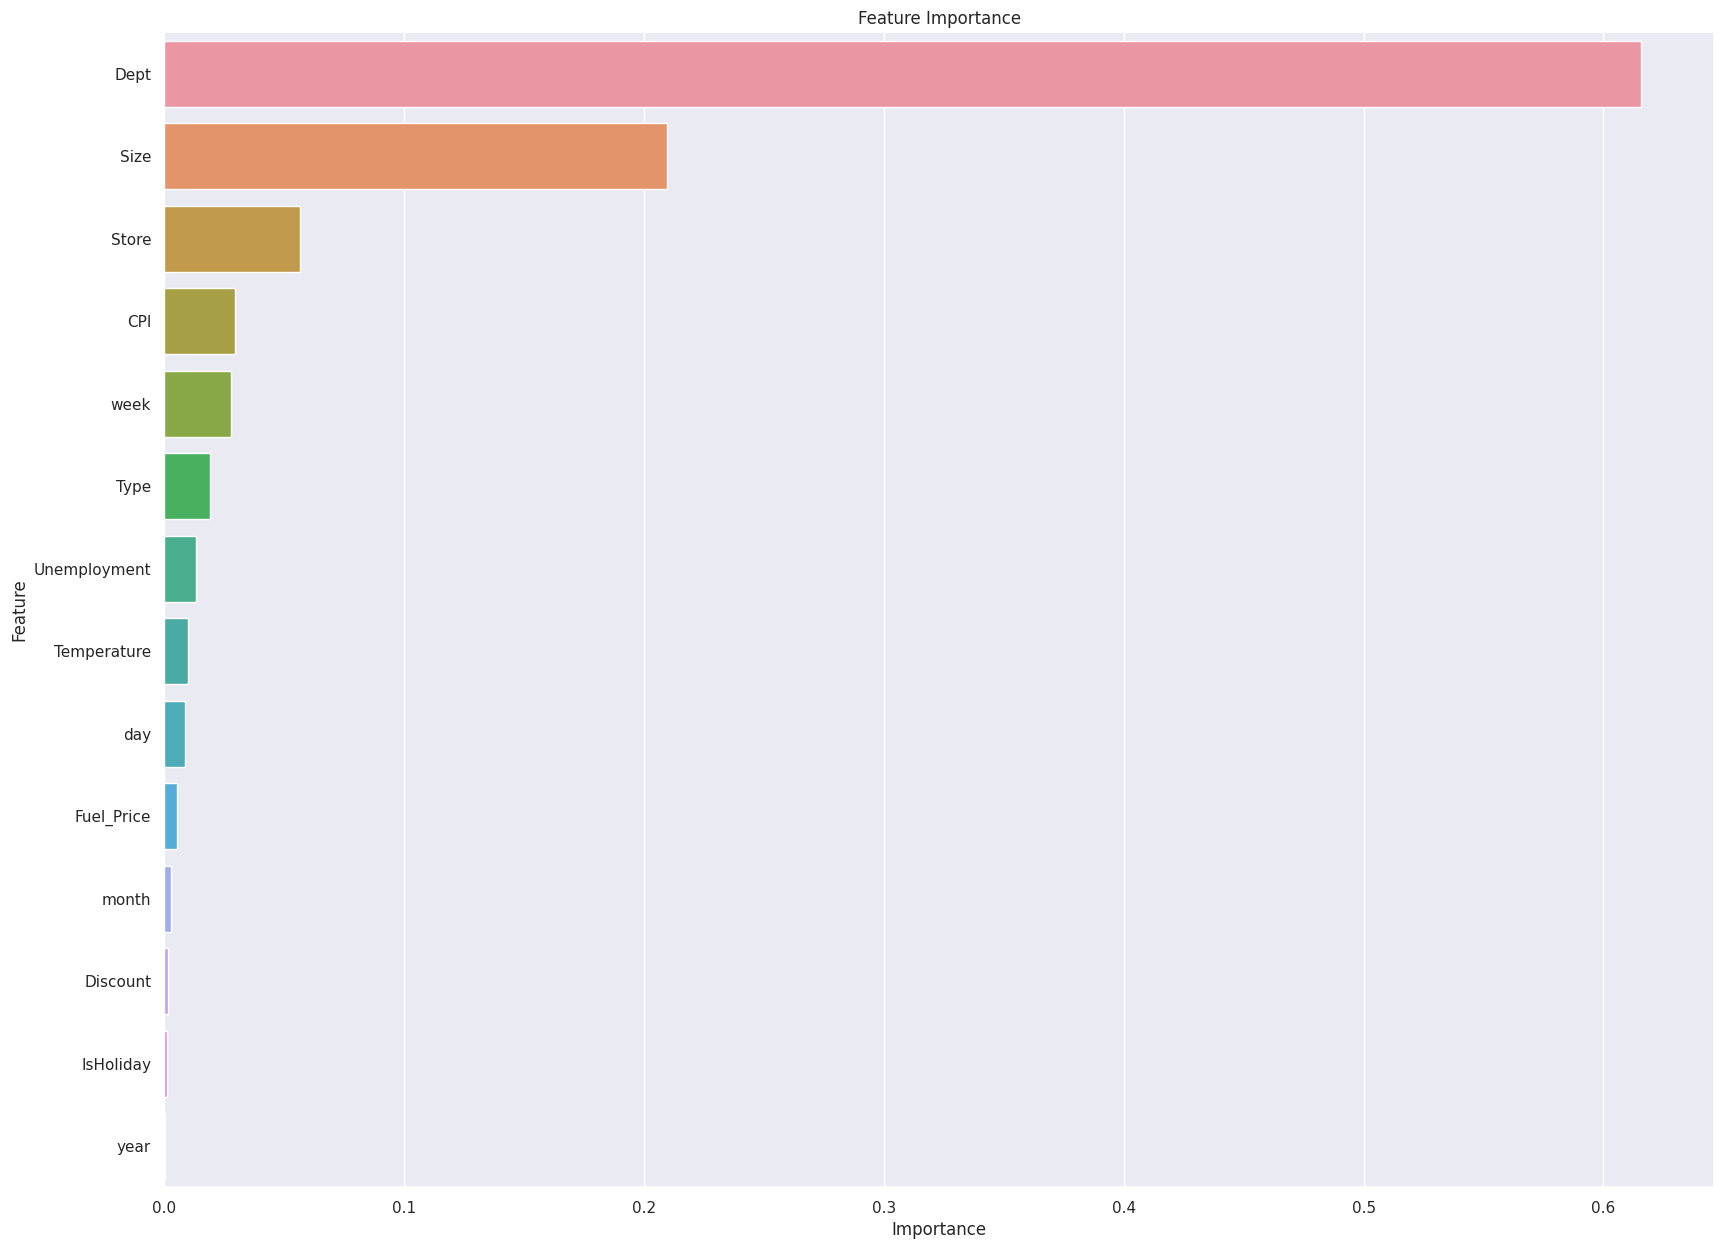

In [34]:
importances = rfr.feature_importances_
feature_names = X_train_nr.columns  
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

#### Попробуем также убрать параметры с маленьким весом

In [35]:
X_train_n_reduce_2 = X_train_nr.drop(columns=['IsHoliday', 'year', 'Discount'])
X_test_n_reduce_2 = X_test_nr.drop(columns=['IsHoliday', 'year', 'Discount'])

rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train_n_reduce_2, y_train_nr)

y_pred = rfr.predict(X_test_n_reduce_2)
print("Точность RandomForestRegressor с 100 < Weekly_Sales < 100_000 и без \'IsHoliday\', \'year\', \'Discount\'")
score(y_test_nr, y_pred)

Точность RandomForestRegressor с 100 < Weekly_Sales < 100_000 и без 'IsHoliday', 'year', 'Discount'
r2_score: 0.9686056416159197
mean_absolute_error: 1747.039452632052
mean_absolute_percentage_error: 0.25388431127066513
mean_squared_error: 10911432.785362085



#### Рассмотрим график Настоящей и Предсказанной цены

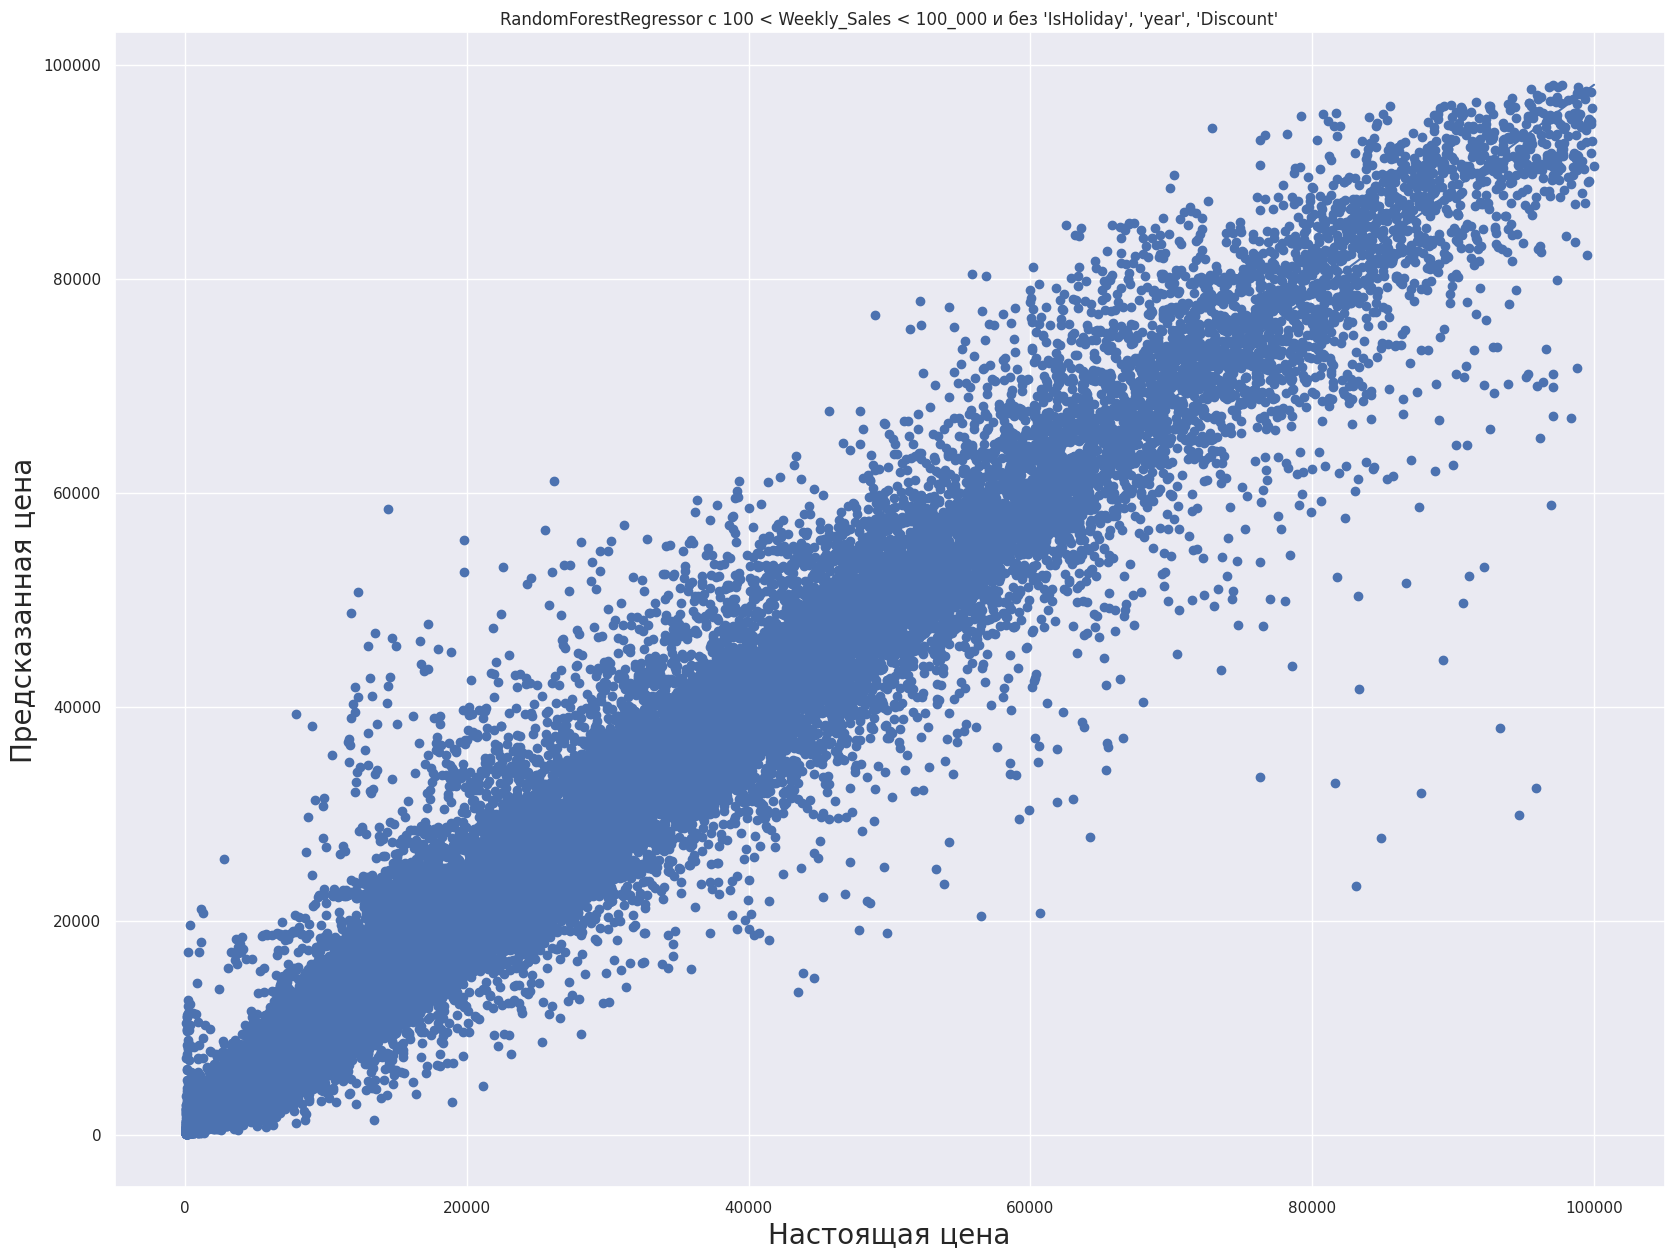

In [36]:
plt.scatter(y_test_nr, y_pred) 
plt.plot([0, max(y_test_nr)], [0, max(y_pred)]) 
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

plt.title('RandomForestRegressor с 100 < Weekly_Sales < 100_000 и без \'IsHoliday\', \'year\', \'Discount\'')
plt.show()

# **Заключение** 
* ### Привели данные в нормальный вид(избавились от пропущенных значений, выбросов, ошибок)
* ### EDA & Feature engineering
* ### Произвели начальное моделирование и получили модель с высокой точностью


# **Дальнейшее моделирование**
#### Попробуем найти лучшее сочетание признаков для повышения точности модели

In [37]:
df_norm.corr()['Weekly_Sales'].sort_values()

Type           -0.182513
Store          -0.085107
Unemployment   -0.025964
CPI            -0.021041
year           -0.009664
day            -0.006271
Temperature    -0.001741
Fuel_Price      0.000307
IsHoliday       0.012711
week            0.027670
month           0.028410
Discount        0.065482
Dept            0.149233
Size            0.244444
Weekly_Sales    1.000000
Name: Weekly_Sales, dtype: float64

#### Проводя разные исследования на основе корреляции, мы пришли к тому, что определенные столбцы ухудшают точность модели. Это столбцы: 'Type', 'Unemployment', 'CPI'.

In [38]:
df_best = df_norm.drop(columns=['Type', 'Unemployment', 'CPI'])

#### Обучим модель и рассмотрим ее точность.

In [39]:
y_best = df_best.Weekly_Sales
X_best = df_best.drop(columns=['Weekly_Sales'])

# Разделяем данные на train и test
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best, y_best, test_size = 0.2, shuffle = True)

In [40]:
rfr = RandomForestRegressor(n_estimators = 100)
rfr.fit(X_train_best, y_train_best)

y_pred = rfr.predict(X_test_best)
print("Точность лучшего RandomForestRegressor")
score(y_test_best, y_pred)

Точность лучшего RandomForestRegressor
r2_score: 0.9801980131207815
mean_absolute_error: 1321.8543718935089
mean_absolute_percentage_error: 0.6863329126815438
mean_squared_error: 10149278.273816774



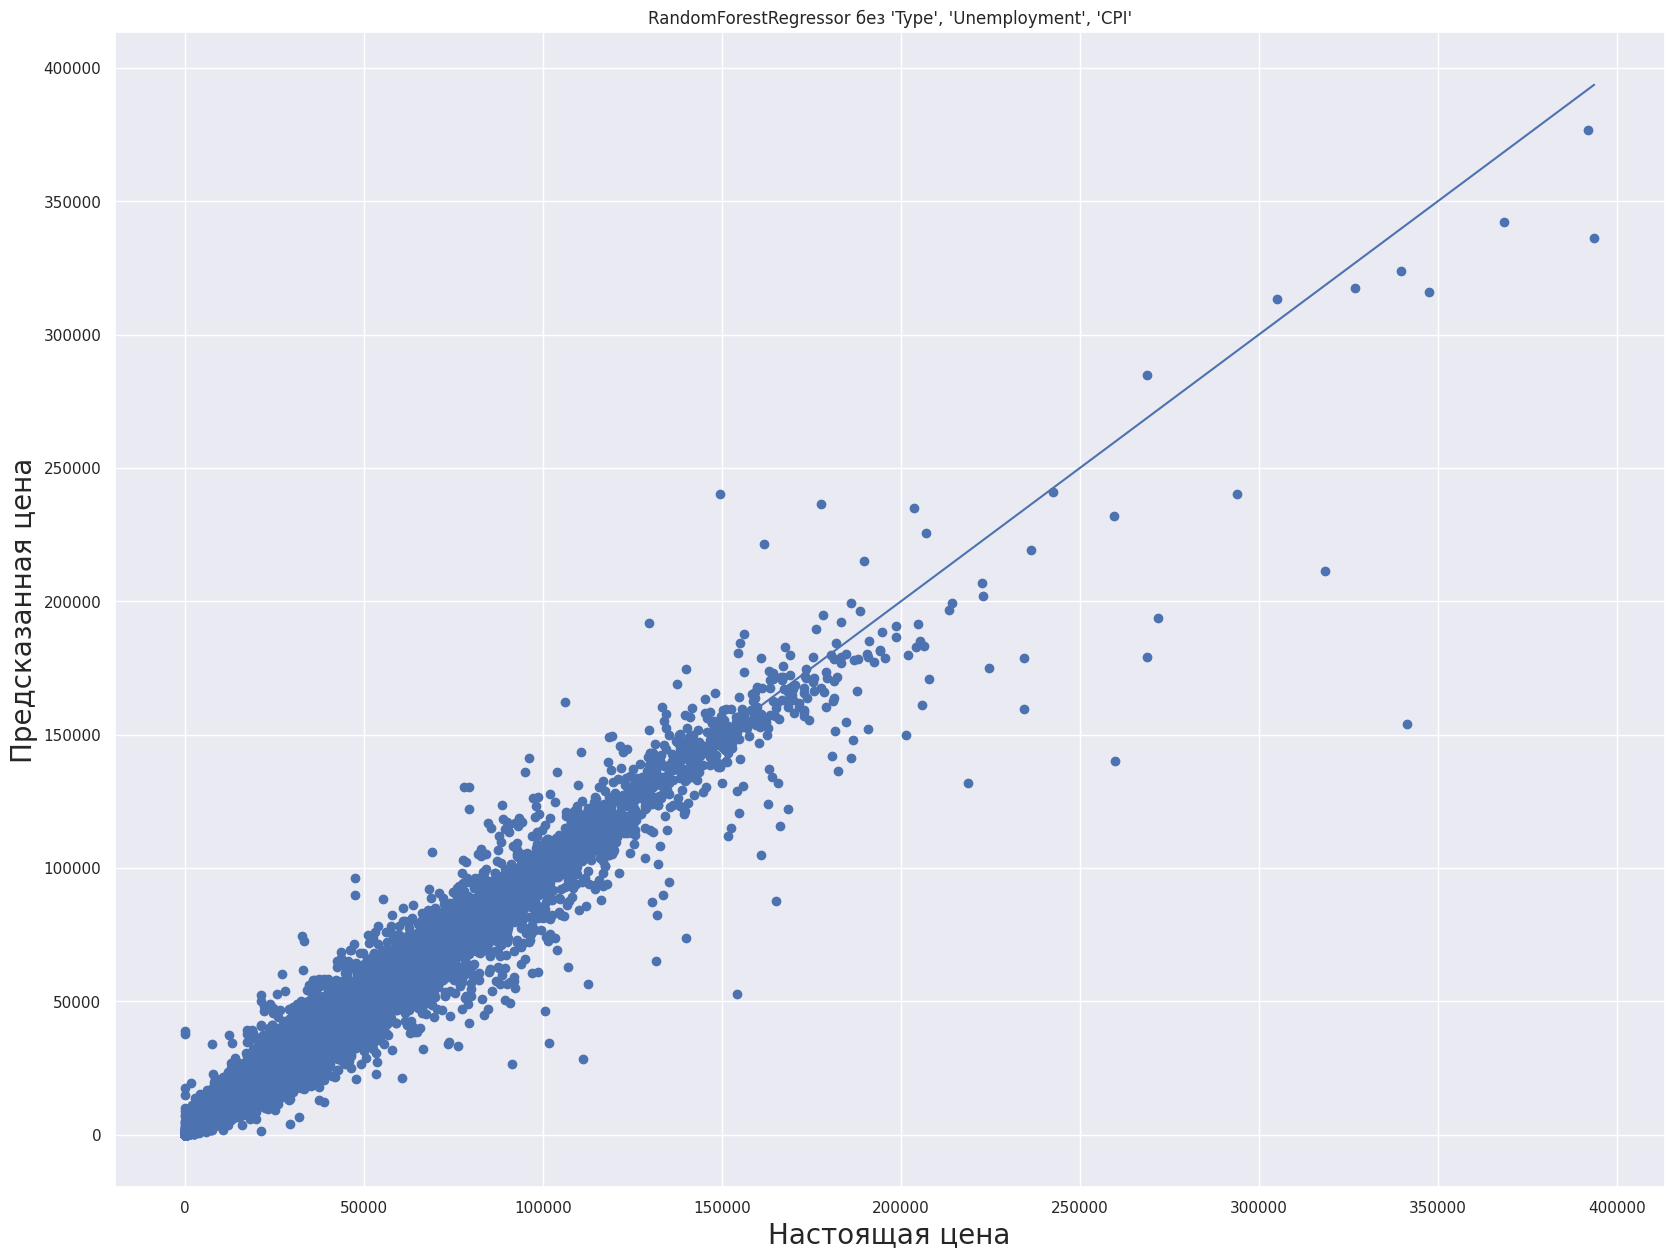

In [41]:
plt.scatter(y_test_best, y_pred)
plt.plot([0, max(y_test_best)], [0, max(y_test_best)]) 
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20);

plt.title('RandomForestRegressor без \'Type\', \'Unemployment\', \'CPI\'')
plt.show()

#### В ходе проведенных моделирований модель случайного леса без столбцов 'Type', 'Unemployment', 'CPI' показала наилучший результат по совокупности метрик.
#### Также мы нашли соревнование https://www.kaggle.com/competitions/walmart-recruiting-store-sales-forecasting/overview, из которого были взяты данные для нашей практики. После загрузки наших прогнозов мы достигли высокой точности в рейтинге соревнования.         
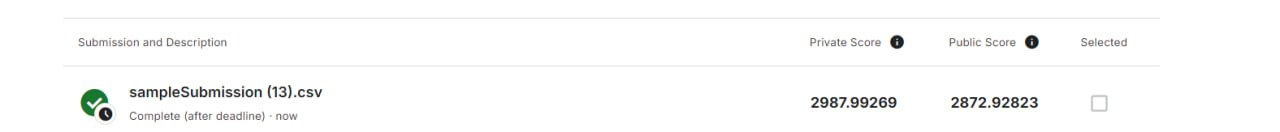

#### Также мы создали прототип приложения, который наглядно показывает предсказания.                       
#### https://github.com/lukianchik/Netology-Practice/blob/main/App.py